In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from algorithms.stabilized_ICA import StabilizedICA
import anndata
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

def ismember(A, B):
    dct = {}
    for s,i in enumerate(B):
        dct[i] = s
    return [ dct[a] for a in A ]


def load_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst = [s.split('[')[0] for s in lst if not s=='']
            sigs[parts[0]] = lst
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def smooth_adata_by_pooling(adata,X_embed,n_neighbours=10):
    adata_pooled = adata.copy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)    
    adata_pooled.X = smooth_matrix_by_pooling(get_nd_array(adata.X),indices)
    if 'matrix' in adata.layers:
        adata_pooled.layers['matrix'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['matrix']),indices)
    if 'spliced' in adata.layers:
        adata_pooled.layers['spliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['spliced']),indices)
    if 'unspliced' in adata.layers:
        adata_pooled.layers['unspliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['unspliced']),indices)
    return adata_pooled


def smooth_matrix_by_pooling(matrix,indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i,:] = np.mean(matrix[indices[i],:],axis=0)
    return matrix_pooled

def get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

def preprocessing_without_pooling(adata):
    if Normalize_Totals:
        med = np.median(adata.obs['total_counts'])
        #med = 10000
        print('Normalizing to the number of counts = ',med)
        sc.pp.normalize_total(adata, target_sum=med)
    if not Already_Log_Transformed:
        print('Taking log...')
        sc.pp.log1p(adata,base=10)
    if top_variable_genes>0:
        print('Selecting genes:',top_variable_genes)
        #sc.pp.highly_variable_genes(adata,n_top_genes=top_variable_genes,n_bins=20)
        #ind_genes = np.where(adata.var['highly_variable'])[0]
        vars = np.var(adata.X,axis=0)
        inds = np.flip(np.argsort(vars))
        ind_genes = inds[0:top_variable_genes]
        if 0 in vars[ind_genes]:
            ind_first_zero = np.argwhere(vars[ind_genes]==0)[0][0]
            ind_genes = ind_genes[0:ind_first_zero]
        #print(vars[ind_genes])
        adata = adata[:,ind_genes]
    sc.tl.pca(adata,n_comps=number_of_pcs)
    return adata

# pooling procedure
def pooling_procedure(adata,adata_orig):
    if n_neighbours_for_pooling>0:    
        adata_work = adata_orig.copy()
        preprocessing_without_pooling(adata)
        sc.tl.pca(adata,n_comps=number_of_pcs)
        X_pca = adata.obsm['X_pca']
        adata = smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=n_neighbours_for_pooling)
    return adata

def preprocessing_dataset(adata):
    adata = preprocessing_without_pooling(adata)    
    sc.tl.pca(adata,n_comps=number_of_pcs)
    display(adata)
    return adata

def calc_weighted_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names_weights = signature_dict[key]
        names = names_weights[0]
        weights = np.array(names_weights[1])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        sel_names = anndata.var_names[inds]
        ind_in_names = ismember(sel_names,names)
        names1 = np.array(names)[ind_in_names]
        weights1 = np.array(weights)[ind_in_names]
        inds = ismember(names1,anndata.var_names)
        matrix_sel = matrix[:,inds]
        gene_means = np.mean(matrix_sel,axis=0)
        meanmat = np.outer(np.ones(matrix_sel.shape[0]),gene_means)
        matrix_sel = matrix_sel-meanmat
        scores = np.matmul(matrix_sel,weights1)
        scores_dic[key] = scores
    return scores_dic

def load_weighted_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst1 = [s.split('[')[0] for s in lst if not s=='']
            weights = [float(s.split('[')[1].split(']')[0]) for s in lst if not s=='']
            #print(lst1,weights)
            sigs[parts[0]] = (lst1,weights)
            #sigs[parts[0]+'_W'] = weights
            line = fin.readline().strip('\n').strip(' ')
    return sigs




/home/zinovyev/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
#folder = '../Broad_CellLine/'
#cell_line = 'JHU011_UPPER_AERODIGESTIVE_TRACT'
#cell_line = 'TE14_OESOPHAGUS'
#cell_line = 'CAMA1_BREAST'
#cell_line = 'SCC47_UPPER_AERODIGESTIVE_TRACT'
#cell_line = 'SCC9_UPPER_AERODIGESTIVE_TRACT'
#cell_line = 'OVTOKO_OVARY'
#cell_line = 'ABC1_LUNG'
##cell_line = 'SCC25_UPPER_AERODIGESTIVE_TRACT'
#suffix = '_raw'
#Normalize_Totals = False
#division_factor = 50

#folder = '../Retinoblastoma/Y79/'
#cell_line = 'Y79'
#suffix = ''
#division_factor = 1
#Normalize_Totals = True

#folder = '/mnt/c/Datas/BIODICA_GUI/work/Y79_nufp10k_ICA/'
#cell_line = 'Y79_nufp10k'
#suffix = ''

folder = '../EwingSarcoma_Miller2020/CHLA9/'
cell_line = 'CHLA9'
division_factor = 1
suffix = ''
Normalize_Totals = True

#folder = '../HeLa/'
#cell_line = 'HELA_WT'
#division_factor = 1
#suffix = ''
#Normalize_Totals = True

#folder = '../HeLa/'
#cell_line = 'HELA_KO'
#division_factor = 1
#suffix = ''
#Normalize_Totals = True


#folder = '../EwingSarcoma_Miller2020/CHLA10/'
#cell_line = 'CHLA10'
#division_factor = 1
#suffix = ''
#Normalize_Totals = True

#folder = '../EwingSarcoma_Miller2020/TC71/'
#cell_line = 'TC71'
#division_factor = 1
#suffix = ''
#Normalize_Totals = True


#folder = '../EwingSarcoma_Aynaud2020/'
#cell_line = 'pdx352'
#division_factor = 1
#suffix = ''
#Normalize_Totals = True


#folder = '../EwingSarcoma_Aynaud2020/'
#cell_line = 'pdx471'
#division_factor = 1
#suffix = ''
#Normalize_Totals = True

In [ ]:
# This cell is specific to Broad cell line collection
# It extracts a cell line from the large CPM_data.txt file
# This step can be done only once and will create a cell_line+'_raw.txt' 
# file containing the CPM counts that need to be pre-processed in the next cell

# Extracting the cell line data

metadata = pd.read_csv(folder+'metadata_header.txt',delimiter='\t')
display(metadata)
cancer_types = list(metadata['Cancer_type'])
cell_lines = list(metadata['Cell_line'])
cellnames = list(metadata['NAME'])

ind_cell_line = np.where(np.array(cell_lines)==cell_line)[0]
with open(folder+'CPM_data.txt') as fin, open(folder+cell_line+'_raw.txt','w') as fout:
    header = fin.readline()[:-1]
    cells = np.array(header.split('\t'))
    ind_cells = [0]+list(ind_cell_line+1)
    fout.write('\t'.join(cells[ind_cells])+'\n')
    ln = fin.readline()[:-1]
    while ln:
        cells = ln.split('\t')
        selected_vals = np.array(cells)[ind_cells[1:]]
        selected_vals = [str(int(float(s))) for s in selected_vals]
        fout.write(cells[0]+'\t'+'\t'.join(selected_vals)+'\n')
        ln = fin.readline()[:-1]

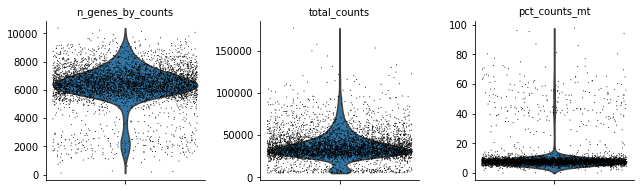

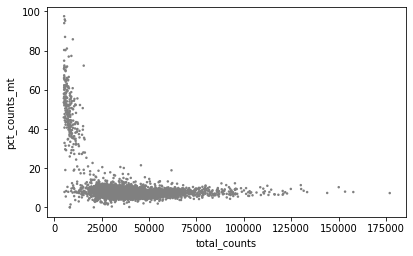

3099 samples pass the count filter
4547  samples pass the mt filter
Samples selected 3044
top_variable_genes taken for pooling: 10000


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Normalizing to the number of counts =  30836.0


/home/zinovyev/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Taking log...
Selecting genes: 10000
Normalizing to the number of counts =  30836.0
Taking log...
Selecting genes: 10000


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 3044 × 10000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [4]:
# Preprocessing the file
# It is normally should be done only once and result in cell_line+'_proc.txt' 
# file. Pay attention that you might want to change the dataset-specific 
# thresholds on the total counts and mt percentage.
# If this is already done then one can open the "_proc.txt" file right away 
# in the next cell

top_variable_genes = 10000 # if negative then no selection of genes
#Normalize_Totals = True
Already_Log_Transformed = False
n_neighbours_for_pooling = 5
number_of_pcs = 20


df = pd.read_csv(folder+cell_line+suffix+'.txt',delimiter='\t')
for i,v in enumerate(df[df.columns[0]].values):
    if v != v:
        df[df.columns[0]][i] = 'UNKNOWN'
adata_k = sc.AnnData(X=df[df.columns[1:]].to_numpy().transpose())
adata_k.obs_names = list(df.columns[1:])
adata_k.var_names = list(df[df.columns[0]])
adata_k.X = adata_k.X/division_factor
adata_k.var_names_make_unique()

# Quality control
adata_k.var['mt'] = adata_k.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_k, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_k, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_k, x='total_counts', y='pct_counts_mt')
inds1 = np.where((adata_k.obs['total_counts']>10000) & (adata_k.obs['total_counts']<40000))
inds2 = np.where(adata_k.obs['pct_counts_mt']<20)
print(len(inds1[0]),'samples pass the count filter')
print(len(inds2[0]),' samples pass the mt filter')
ind_samples = np.intersect1d(inds1[0],inds2[0])
print('Samples selected',len(ind_samples))
adata_k = adata_k[ind_samples,:]


if n_neighbours_for_pooling>0:
    #temp_top_variable_genes = top_variable_genes
    #adata_k_temp = adata_k.copy()
    #top_variable_genes = -1
    #adata_k_temp = preprocessing_without_pooling(adata_k_temp)
    #top_variable_genes = np.sum(np.var(adata_k_temp.X,axis=0)>0.01)
    #top_variable_genes = 5000
    print('top_variable_genes taken for pooling:',top_variable_genes)
    adata_k1 = pooling_procedure(adata_k,adata_k)
    #top_variable_genes = temp_top_variable_genes
    adata_k1 = preprocessing_dataset(adata_k1)
else:
    adata_k1 = preprocessing_dataset(adata_k)
dc = {'GENE':list(adata_k1.var_names)}
for j,s in enumerate(adata_k1.obs_names):
    dc[s] = adata_k1.X[j,:]
pd.DataFrame(data=dc).to_csv(folder+cell_line+'_proc.txt',sep='\t',index=False)

In [5]:
#file = folder+cell_line+'.txt'
#df = pd.read_csv(file , sep='\t', index_col=0)
#df = df.transpose()
#display(df)

In [5]:
file = folder+cell_line+'_proc.txt'
df = pd.read_csv(file , sep='\t', index_col=0)
df = df.transpose()
display(df)

GENE,HIST1H4C,HIST1H1B,ASPM,CCNB1,CDC20,HIST1H1D,DLGAP5,TOP2A,TPX2,ARL6IP1,...,ASB3,WWP2,ITPKA,RASL11B,NACAD,CCT8,AK1,EEF1B2,TBCCD1,AC008608.2
AAACCCAGTTGTACGT-1,0.794804,0.146951,0.416744,0.146951,0.146951,0.205200,0.079662,0.479039,0.533510,0.146951,...,0.000000,0.000000,0.000000,0.146951,0.079662,1.103017,0.079662,1.682242,0.079662,0.146951
AAACGAAAGACCCGCT-1,0.338640,0.000000,1.347458,1.380717,1.315593,0.078029,1.079974,1.524725,1.387774,1.272162,...,0.000000,0.078029,0.000000,0.000000,0.000000,1.093967,0.078029,1.597440,0.201523,0.000000
AAAGAACCACGGTGTC-1,0.615902,0.000000,0.960794,1.124163,1.058115,0.000000,0.713719,1.163201,1.073684,0.989571,...,0.000000,0.000000,0.151453,0.082296,0.000000,1.137569,0.263528,1.684490,0.000000,0.151453
AAAGAACCATCCTATT-1,0.996357,0.223481,0.656380,0.303069,0.067530,0.337987,0.125959,0.858820,0.400385,0.303069,...,0.000000,0.125959,0.125959,0.125959,0.067530,1.045093,0.000000,1.556217,0.000000,0.067530
AAAGAACGTCTGTTAG-1,0.666276,0.000000,0.162767,0.329742,0.162767,0.088964,0.162767,0.544158,0.280887,0.162767,...,0.000000,0.162767,0.088964,0.088964,0.088964,1.100173,0.000000,1.569922,0.162767,0.088964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCATCACCC-1,0.577122,0.000000,0.502667,0.202768,0.000000,0.078581,0.145098,0.553694,0.253669,0.078581,...,0.000000,0.145098,0.078581,0.000000,0.145098,1.103878,0.000000,1.707418,0.000000,0.000000
TTTGGTTTCCAAGCTA-1,1.927784,1.094341,1.010378,0.428189,0.223271,1.117219,0.454596,1.169638,0.837662,0.264857,...,0.125828,0.125828,0.125828,0.177277,0.000000,1.063938,0.067455,1.677107,0.223271,0.000000
TTTGTTGAGAACGCGT-1,1.486011,0.602963,0.520365,0.284575,0.333860,0.488929,0.000000,1.010994,0.378117,0.333860,...,0.000000,0.090402,0.000000,0.000000,0.090402,1.115054,0.000000,1.678925,0.165191,0.000000
TTTGTTGAGGACATCG-1,1.057445,0.405319,0.437068,0.371065,0.333877,0.198263,0.248322,0.855602,0.590265,0.198263,...,0.000000,0.000000,0.076588,0.076588,0.000000,1.143680,0.198263,1.633897,0.000000,0.000000


(10000,)
running time (min): 01:01.95


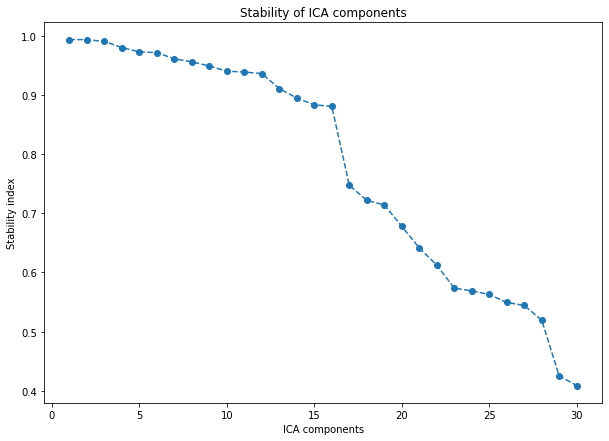

In [8]:
start = time.time()

X = df.values
#Uncomment next line if you want to subsample the dataset
#X = X[np.random.choice(X.shape[0],1000),:]
mn = np.mean(X,axis=0)
print(mn.shape)
X = X - mn
X = X.T

sICA = StabilizedICA(n_components = 30 , max_iter = 2000, n_jobs = -1)
sICA.fit(X, n_runs = 100, plot = True, normalize=True, fun='logcosh')

end = time.time()

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

In [9]:
Metagenes = pd.DataFrame(sICA.S_ , columns = df.columns , index = ['IC'+ str(i+1) for i in range(sICA.S_.shape[0])])
display(Metagenes)
sfile = file[:-4]+"_PT_S.xls"
print(sfile)
Metagenes.transpose().to_csv(sfile,sep='\t')

#sfile = 'Y79_nufp10k_ica_S.xls'
#sfile = '/mnt/c/Datas/BIODICA_GUI/work/CHLA9_nufp10k_ICA/CHLA9_nufp10k_ica_S.xls'
#sfile = '/mnt/c/Datas/BIODICA_GUI/work/CHLA9_proc_ICA/CHLA9_proc_ica_S.xls'
#temp = pd.read_csv(sfile,delimiter='\t',index_col=False).transpose()
#Xtemp = temp.to_numpy()[1:-1,:]
#Metagenes = pd.DataFrame(Xtemp, columns = list(temp.to_numpy()[0,:]), index = ['IC'+ str(i+1) for i in range(Xtemp.shape[0])])
#display(Metagenes)

GENE,HIST1H4C,HIST1H1B,ASPM,CCNB1,CDC20,HIST1H1D,DLGAP5,TOP2A,TPX2,ARL6IP1,...,ASB3,WWP2,ITPKA,RASL11B,NACAD,CCT8,AK1,EEF1B2,TBCCD1,AC008608.2
IC1,2.232170,0.320171,3.929276,-3.497893,-2.454652,0.020341,-2.765148,-1.305979,-0.504977,-2.992305,...,0.016041,0.038243,0.167591,0.670490,-0.169285,-0.212016,0.072981,0.117829,0.034136,-0.114024
IC2,0.496498,1.122624,-0.450664,0.211649,0.239982,0.722401,1.054857,-0.090026,0.025154,0.187576,...,0.219481,0.236219,0.054449,0.119244,0.699837,-0.382104,-0.009572,0.491029,0.220466,0.646567
IC3,26.455008,23.080873,-0.413678,-4.972543,-4.742794,20.764289,-1.415158,5.550451,1.512741,-4.142113,...,0.104330,-0.240132,1.446157,-0.807144,0.126623,-0.604612,-0.057855,0.875304,-0.356706,0.138071
IC4,-2.783633,0.540815,0.644987,0.124108,-0.559978,0.770986,1.338879,0.499774,2.085181,-1.007292,...,-0.162186,-0.670899,-0.364194,-0.543897,-0.422400,0.406862,-0.005099,-1.519839,-0.727128,-0.069895
IC5,-1.655704,-1.528082,0.774984,-0.107979,-2.036035,-0.546387,-2.642283,-2.244080,0.169136,-1.033902,...,0.110432,-0.151699,1.126361,-0.631913,0.124932,0.163647,-0.402548,-0.793630,0.993558,0.707961
IC6,0.160425,1.397018,1.276092,-1.104271,-0.057382,0.294877,0.839336,-1.470643,0.054841,0.582219,...,-0.530694,0.414726,0.060448,0.067284,-0.315293,-0.053829,-0.662941,-0.909903,-0.216865,-0.255206
IC7,13.723174,2.353172,0.792625,-0.273470,-1.176187,2.114491,1.209111,-1.445846,-0.095239,-1.171857,...,-0.262377,-0.293325,0.344491,0.427185,-0.176632,0.144432,-0.367061,0.238796,-0.200176,0.444325
IC8,2.060756,0.735870,-2.134332,1.354889,1.387741,1.096818,0.263735,-1.776291,-1.069533,-0.401719,...,-0.580851,-0.370792,-0.037110,-0.398924,-0.453603,0.788551,-1.232436,-0.572867,0.102077,-0.068713
IC9,3.729478,1.695373,14.511995,10.996287,9.393885,0.886093,8.139634,11.954895,9.646301,8.253071,...,-0.141406,0.047632,0.192985,-0.272319,-0.116540,-0.443163,-0.171038,-0.175785,-0.046646,-0.508872
IC10,0.324729,-0.914377,-0.137803,-0.064188,0.926865,-0.773764,1.171010,0.813310,-1.162534,-0.110499,...,0.020009,-0.347916,-0.193882,0.133542,0.251015,-0.486262,-0.344778,-0.166369,-0.362818,0.254130


../EwingSarcoma_Miller2020/CHLA9/CHLA9_proc_PT_S.xls


G2M -> IC9 ( 10.099738422938264 )
G2M_INH -> IC16 ( 7.0677973190144145 )
G1S -> IC1 ( 7.109655020022363 )
HISTONES -> IC3 ( 16.212177396498248 )


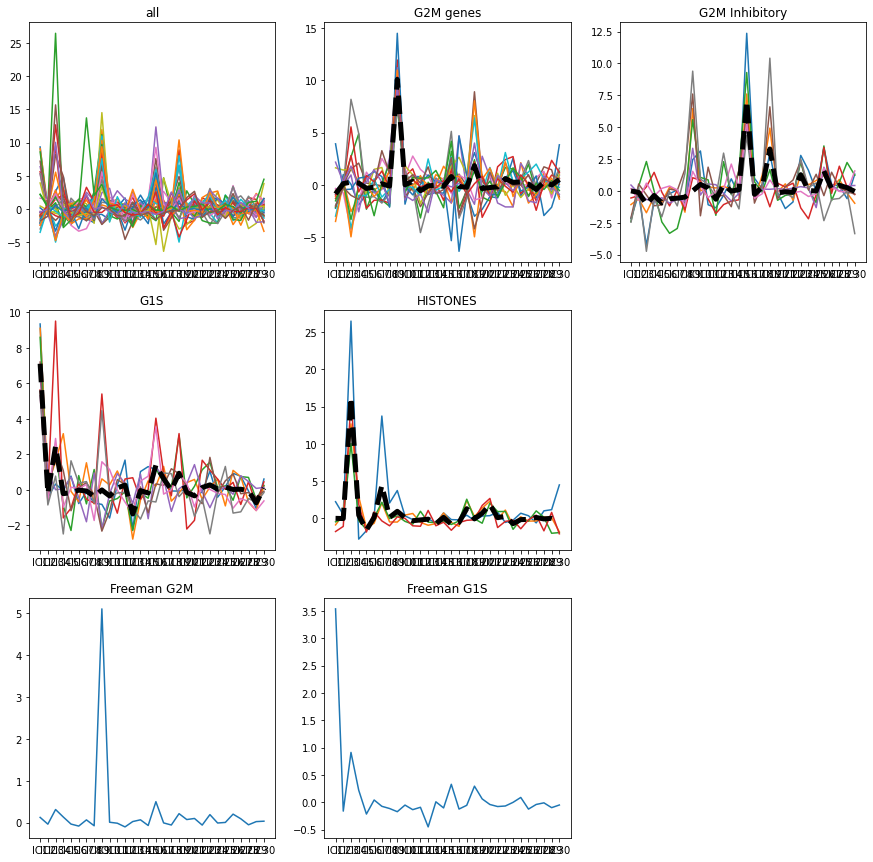

In [10]:
freeman_G1S = ['ADAMTS1','ASF1B','ATAD2','BARD1','BLM','BRCA1','BRIP1','C17orf75','C9orf40','CACYBP','CASP8AP2','CCDC15','CCNE1','CCNE2','CCP110','CDC25A','CDC45','CDC6','CDC7','CDK2','CDT1','CENPJ','CENPQ','CENPU','CEP57','CHAF1A','CHAF1B','CHEK1','CLSPN','CREBZF','CRYL1','CSE1L','DCLRE1B','DCTPP1','DEK','DERA','DHFR','DNA2','DNAJC9','DNMT1','DONSON','DSCC1','DSN1','DTL','E2F8','EED','EFCAB11','ENDOD1','ETAA1','EXO1','EYA2','EZH2','FAM111A','FANCE','FANCG','FANCI','FANCL','FBXO5','FEN1','GGH','GINS1','GINS2','GINS3','GLMN','GMNN','GMPS','GPD2','HADH','HELLS','HSF2','ITGB3BP','KIAA0101','KNTC1','LIG1','MCM10','MCM2','MCM3','MCM4','MCM5','MCM6','MCM7','MCMBP','METTL9','MMD','MNS1','MPP1','MRE11A','MSH2','MSH6','MYO19','NASP','NPAT','NSMCE4A','ORC1','OSGEPL1','PAK1','PAQR4','PARP2','PASK','PAXIP1','PBX3','PCNA','PKMYT1','PMS1','POLA1','POLA2','POLD3','POLE2','PRIM1','PRPS2','PSMC3IP','RAB23','RAD51','RAD51AP1','RAD54L','RBBP8','RBL1','RDX','RFC2','RFC3','RFC4','RMI1','RNASEH2A','RPA1','RRM1','RRM2','SLBP','SLC25A40','SMC2','SMC3','SSX2IP','SUPT16H','TEX30','TFDP1','THAP10','THEM6','TIMELESS','TIPIN','TMEM106C','TMEM38B','TRIM45','TRIP13','TSPYL4','TTI1','TUBGCP5','TYMS','UBR7','UNG','USP1','WDHD1','WDR76','WRB','YEATS4','ZBTB14','ZWINT']
freeman_G2M = ['ADGRE5','ARHGAP11A','ARHGDIB','ARL6IP1','ASPM','AURKA','AURKB','BIRC5','BORA','BRD8','BUB1','BUB1B','BUB3','CCNA2','CCNB1','CCNB2','CCNF','CDC20','CDC25B','CDC25C','CDC27','CDCA3','CDCA8','CDK1','CDKN1B','CDKN3','CENPE','CENPF','CENPI','CENPN','CEP55','CEP70','CEP85','CKAP2','CKAP5','CKS1B','CKS2','CTCF','DBF4','DBF4B','DCAF7','DEPDC1','DLGAP5','ECT2','ERCC6L','ESPL1','FAM64A','FOXM1','FZD2','FZD7','FZR1','GPSM2','GTF2E1','GTSE1','H2AFX','HJURP','HMGB2','HMGB3','HMMR','HN1','INCENP','JADE2','KIF11','KIF14','KIF15','KIF18A','KIF18B','KIF20A','KIF20B','KIF22','KIF23','KIF2C','KIF4A','KIF5B','KIFC1','KPNA2','LBR','LMNB2','MAD2L1','MELK','MET','METTL4','MIS18BP1','MKI67','MPHOSPH9','MTMR6','NCAPD2','NCAPG','NCAPG2','NCAPH','NDC1','NDC80','NDE1','NEIL3','NEK2','NRF1','NUSAP1','OIP5','PAFAH2','PARPBP','PBK','PLEKHG3','PLK1','PLK4','PRC1','PRR11','PSRC1','PTTG1','PTTG3P','RACGAP1','RAD21','RASSF1','REEP4','SAP30','SHCBP1','SKA1','SLCO1B3','SOGA1','SPA17','SPAG5','SPC25','SPDL1','STIL','STK17B','TACC3','TAF5','TBC1D2','TBC1D31','TMPO','TOP2A','TPX2','TROAP','TTF2','TTK','TUBB4B','TUBD1','UBE2C','UBE2S','VANGL1','WEE1','WHSC1','XPO1','ZMYM1']
#g2m_markers = ['CDK1','MKI67','CCNB2','AURKB']
g2m_markers = ['UBE2C','AURKA','CENPF','TOP2A','CKS2','TPX2','PLK1','MKI67','HMGB2','ARL6IP1','ASPM','CCNB1','KPNA2','GTSE1','NUSAP1','CENPA']
#g1s_markers = ['RRM2','PCNA','MCM10','ORC6']
g1s_markers = ['CLSPN','ATAD2','PCNA','RRM2','GINS2','HELLS','DUT','UBE2T']
#g2m_inhibitory_markers = ['CDC20','CDKN3','UBE2S','UBE2C','UBB','PSMA7','PSMB2']
g2m_inhibitory_markers = ['PTTG1','CDKN3','BIRC5','HMGN2','CKS1B','UBE2S','CENPW','CDC20']
#histone_markers = ['HIST1H4C','HIST1H1E','HIST2H2AC']
histone_markers = ['HIST1H4C','HIST1H1E','HIST2H2AC','HIST1H1C']

freeman_G1S = [s for s in freeman_G1S if s in Metagenes]
freeman_G2M = [s for s in freeman_G2M if s in Metagenes]
g2m_markers = [s for s in g2m_markers if s in Metagenes]
g1s_markers = [s for s in g1s_markers if s in Metagenes]
g2m_inhibitory_markers = [s for s in g2m_inhibitory_markers if s in Metagenes]
histone_markers = [s for s in histone_markers if s in Metagenes]

g2m_score = np.mean(Metagenes[g2m_markers],axis=1)
g1s_score = np.mean(Metagenes[g1s_markers],axis=1)
g2m_inhibitory_score = np.mean(Metagenes[g2m_inhibitory_markers],axis=1)
histone_score = np.mean(Metagenes[histone_markers],axis=1)

idx_g2m_signal = np.argmax(g2m_score)
g2m_inhibitory_score[idx_g2m_signal] = 0
g1s_score[idx_g2m_signal] = 0
idx_g1s_signal = np.argmax(g1s_score)
histone_score[idx_g1s_signal] = 0
g2m_inhibitory_score[idx_g1s_signal] = 0
idx_g2m_inhibitory_signal = np.argmax(g2m_inhibitory_score)
idx_histone_signal = np.argmax(histone_score)

print('G2M ->','IC'+str(idx_g2m_signal+1),'(',g2m_score[idx_g2m_signal],')')
print('G2M_INH ->','IC'+str(idx_g2m_inhibitory_signal+1),'(',g2m_inhibitory_score[idx_g2m_inhibitory_signal],')')
print('G1S ->','IC'+str(idx_g1s_signal+1),'(',g1s_score[idx_g1s_signal],')')
print('HISTONES ->','IC'+str(idx_histone_signal+1),'(',histone_score[idx_histone_signal],')')

fig = plt.figure(figsize=(15,15))

plt.subplot(3,3,1)
plt.plot(Metagenes[g1s_markers+g2m_markers+g2m_inhibitory_markers+histone_markers])
plt.title('all')

plt.subplot(3,3,2)
plt.plot(Metagenes[g2m_markers])
plt.plot(g2m_score,'k--',linewidth=5)
plt.title('G2M genes')

plt.subplot(3,3,3)
plt.plot(Metagenes[g2m_inhibitory_markers])
plt.plot(g2m_inhibitory_score,'k--',linewidth=5)
plt.title('G2M Inhibitory')

plt.subplot(3,3,4)
plt.plot(Metagenes[g1s_markers])
plt.plot(g1s_score,'k--',linewidth=5)
plt.title('G1S')

plt.subplot(3,3,5)
plt.plot(Metagenes[histone_markers])
plt.plot(histone_score,'k--',linewidth=5)
plt.title('HISTONES')

plt.subplot(3,3,7)
plt.plot(np.mean(Metagenes[freeman_G2M],axis=1))
plt.title('Freeman G2M')

plt.subplot(3,3,8)
plt.plot(np.mean(Metagenes[freeman_G1S],axis=1))
plt.title('Freeman G1S')
plt.show()

/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


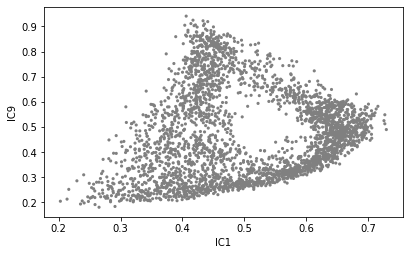

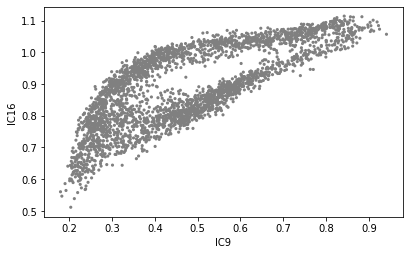

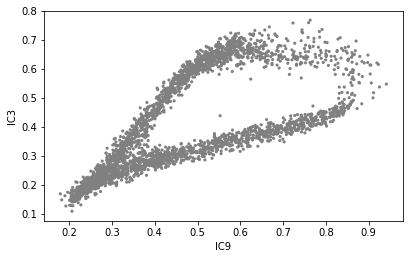

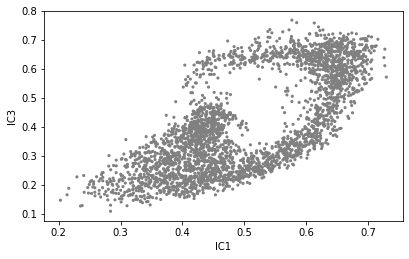

In [11]:
gmtfile = sfile[:-4]+'.gmt'

threshold = 3
dfs = pd.read_csv(sfile,delimiter='\t')
dfs1 = dfs[dfs.columns[1:]]
with open(gmtfile,'w') as fout:
    for s in dfs1.columns:
        fout.write(s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs[dfs.columns[0]].iloc[i]
            if val>threshold:
                fout.write(gn+'\t')
        fout.write('\n')
        
threshold = 2
dfs = pd.read_csv(sfile,delimiter='\t')
dfs1 = dfs[dfs.columns[1:]]
gmtfile_weighted = sfile[:-4]+'_weighted.gmt'
with open(gmtfile_weighted,'w') as fout:
    for s in dfs1.columns:
        fout.write(s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs[dfs.columns[0]].iloc[i]
            if abs(val)>threshold:
                fout.write(gn+'['+str(val)+']'+'\t')
        fout.write('\n')

signature_dict = load_signature_file(gmtfile)

adata = sc.AnnData(X=df.to_numpy())
adata.var_names = list(df.columns)
adata.obs_names = list(df.index)

sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]
scores_dic = calc_scores(adata2k,signature_dict)
#scores_dic = calc_weighted_scores(adata2k,signature_dict)
for s in scores_dic:
    adata.obs[s] = scores_dic[s]

sc.pl.scatter(adata,x='IC'+str(idx_g1s_signal+1),y='IC'+str(idx_g2m_signal+1))
sc.pl.scatter(adata,x='IC'+str(idx_g2m_signal+1),y='IC'+str(idx_g2m_inhibitory_signal+1))
sc.pl.scatter(adata,x='IC'+str(idx_g2m_signal+1),y='IC'+str(idx_histone_signal+1))
sc.pl.scatter(adata,x='IC'+str(idx_g1s_signal+1),y='IC'+str(idx_histone_signal+1))

In [165]:
#sc.pl.scatter(adata,x='IC'+str(idx_g1s_signal+1),y='IC24')
#sc.pl.scatter(adata,x='IC'+str(idx_g2m_inhibitory_signal+1),y='IC14')

Text(0.5, 1.0, 'G2M Inhibitory')

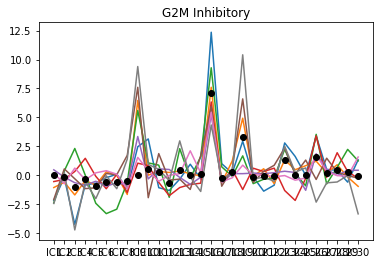

In [12]:
plt.plot(Metagenes[g2m_inhibitory_markers])
plt.plot(g2m_inhibitory_score,'ko',linewidth=5)
plt.title('G2M Inhibitory')


In [393]:
import os
from os import listdir
from os.path import isfile, join

# Batch decomposition of multiple cell lines
folder_batch = '../Broad_CellLine/cell_lines/'
files = [f for f in listdir(folder_batch) if (isfile(join(folder_batch, f)))&('_proc' in f)&(f.endswith('.txt'))]
#print(files)
#if False:
i=1
for file in files:
    sfile = folder_batch+file[:-4]+"_PT_S.xls"    
    if not os.path.exists(sfile):
        print(i,'Decomposing',file)
        df = pd.read_csv(folder_batch+file , sep='\t', index_col=0)
        df = df.transpose()
        start = time.time()
        X = df.values
        mn = np.mean(X,axis=0)
        X = X - mn
        sICA = StabilizedICA(n_components = 30 , max_iter = 2000, n_jobs = -1)
        sICA.fit(X, n_runs = 100, plot = False, normalize=True, fun='logcosh')
        end = time.time()
        minutes, seconds = divmod(end - start, 60)
        print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))    
        Metagenes = pd.DataFrame(sICA.S_ , columns = df.columns , index = ['IC'+ str(i+1) for i in range(sICA.S_.shape[0])])
        Metagenes.transpose().to_csv(sfile,sep='\t')
        i = i+1



1 Decomposing 42MGBA_CENTRAL_NERVOUS_SYSTEM_proc.txt
running time (min): 00:45.88
2 Decomposing 8305C_THYROID_proc.txt
running time (min): 00:48.30
3 Decomposing 93VU_UPPER_AERODIGESTIVE_TRACT_proc.txt
running time (min): 00:47.04
4 Decomposing A375_SKIN_proc.txt
running time (min): 00:45.29
5 Decomposing BFTC909_KIDNEY_proc.txt
running time (min): 00:49.80
6 Decomposing C32_SKIN_proc.txt
running time (min): 00:49.73
7 Decomposing CL34_LARGE_INTESTINE_proc.txt
running time (min): 00:41.87
8 Decomposing COLO680N_OESOPHAGUS_proc.txt
running time (min): 00:46.71
9 Decomposing HEC59_ENDOMETRIUM_proc.txt
running time (min): 00:33.93
10 Decomposing HOS_BONE_proc.txt
running time (min): 00:38.67
11 Decomposing HT1080_SOFT_TISSUE_proc.txt
running time (min): 00:44.50
12 Decomposing IGR1_SKIN_proc.txt
running time (min): 00:37.30
13 Decomposing JHU011_UPPER_AERODIGESTIVE_TRACT_proc.txt
running time (min): 00:36.33
14 Decomposing JHU029_UPPER_AERODIGESTIVE_TRACT_proc.txt
running time (min): 00:3

In [392]:
folder_batch = '../Broad_CellLine/cell_lines_raw/'
files = [f for f in listdir(folder_batch) if (isfile(join(folder_batch, f)))&('_raw' in f)&(f.endswith('.txt'))]
#print(files)

i=1
for file in files:
    proc_file = folder_batch+file[:-8]+'_proc.txt'
    if not os.path.exists(proc_file):        
        print(i,'Processing',file)
        df = pd.read_csv(folder_batch+file,delimiter='\t')
        adata_k = sc.AnnData(X=df[df.columns[1:]].to_numpy().transpose())
        adata_k.obs_names = list(df.columns[1:])
        adata_k.var_names = list(df[df.columns[0]])
        adata_k.X = adata_k.X/division_factor
        if len(adata_k.obs_names)>350:
            if (n_neighbours_for_pooling>0)&(len(adata_k.obs_names)>350):
                print('pooling...')
                adata_k1 = pooling_procedure(adata_k,adata_k)
                adata_k1 = preprocessing_dataset(adata_k1)
            else:
                adata_k1 = preprocessing_dataset(adata_k)
            dc = {'GENE':list(adata_k1.var_names)}
            for j,s in enumerate(adata_k1.obs_names):
                dc[s] = adata_k1.X[j,:]
            pd.DataFrame(data=dc).to_csv(proc_file,sep='\t',index=False)
            i=i+1


1 Processing A204_SOFT_TISSUE_raw.txt
1 Processing A2058_SKIN_raw.txt
1 Processing ABC1_LUNG_raw.txt
1 Processing ASPC1_PANCREAS_raw.txt
1 Processing BICR16_UPPER_AERODIGESTIVE_TRACT_raw.txt
1 Processing BICR31_UPPER_AERODIGESTIVE_TRACT_raw.txt
1 Processing BICR6_UPPER_AERODIGESTIVE_TRACT_raw.txt
1 Processing BT549_BREAST_raw.txt
1 Processing CAKI2_KIDNEY_raw.txt
1 Processing CALU6_LUNG_raw.txt
1 Processing CAMA1_BREAST_raw.txt
1 Processing CAOV3_OVARY_raw.txt
1 Processing CCFSTTG1_CENTRAL_NERVOUS_SYSTEM_raw.txt
1 Processing COLO741_SKIN_raw.txt
1 Processing COLO792_SKIN_raw.txt
1 Processing DAOY_CENTRAL_NERVOUS_SYSTEM_raw.txt
1 Processing DKMG_CENTRAL_NERVOUS_SYSTEM_raw.txt
1 Processing EFM192A_BREAST_raw.txt
1 Processing HCC1419_BREAST_raw.txt
1 Processing HCC366_LUNG_raw.txt
1 Processing HEC151_ENDOMETRIUM_raw.txt
1 Processing HMC18_BREAST_raw.txt
1 Processing HS729_SOFT_TISSUE_raw.txt
1 Processing HS939T_SKIN_raw.txt
1 Processing HT55_LARGE_INTESTINE_raw.txt
1 Processing HUCCT1_BIL

In [109]:
from shutil import copyfile

metadata = pd.read_csv(folder+'metadata_header.txt',delimiter='\t')
cell_lines = list(metadata['Cell_line'])

folder_batch = '../Broad_CellLine/cell_lines/'
folder_2copy = '../Broad_CellLine/cell_lines_metaanalysis/'
files = [f for f in listdir(folder_batch) if (isfile(join(folder_batch, f)))&('_proc' in f)&(f.endswith('_S.xls'))]
#print(files)
#if False:
i=1
for file in files:
    cl = file[:-14]
    n = cell_lines.count(cl)
    print(cl,n)
    if n>300:
        copyfile(folder_batch+file, folder_2copy+file)
    


42MGBA_CENTRAL_NERVOUS_SYSTEM 518
8305C_THYROID 459
93VU_UPPER_AERODIGESTIVE_TRACT 572
A204_SOFT_TISSUE 250
A2058_SKIN 294
A375_SKIN 593
ABC1_LUNG 311
ASPC1_PANCREAS 290
BFTC909_KIDNEY 379
BICR16_UPPER_AERODIGESTIVE_TRACT 212
BICR31_UPPER_AERODIGESTIVE_TRACT 248
BICR6_UPPER_AERODIGESTIVE_TRACT 286
BT549_BREAST 266
C32_SKIN 554
CAKI2_KIDNEY 278
CALU6_LUNG 258
CAMA1_BREAST 291
CAOV3_OVARY 221
CCFSTTG1_CENTRAL_NERVOUS_SYSTEM 246
CL34_LARGE_INTESTINE 378
COLO680N_OESOPHAGUS 523
COLO741_SKIN 329
COLO792_SKIN 271
DAOY_CENTRAL_NERVOUS_SYSTEM 281
DKMG_CENTRAL_NERVOUS_SYSTEM 271
EFM192A_BREAST 333
HCC1419_BREAST 221
HCC366_LUNG 202
HEC151_ENDOMETRIUM 250
HEC59_ENDOMETRIUM 385
HMC18_BREAST 293
HOS_BONE 829
HS729_SOFT_TISSUE 215
HS939T_SKIN 236
HT1080_SOFT_TISSUE 516
HT55_LARGE_INTESTINE 211
HUCCT1_BILIARY_TRACT 241
HUH6_LIVER 338
IALM_LUNG 322
IGR1_SKIN 725
IGR37_SKIN 347
JHH6_LIVER 206
JHOS2_OVARY 213
JHU006_UPPER_AERODIGESTIVE_TRACT 325
JHU011_UPPER_AERODIGESTIVE_TRACT 717
JHU029_UPPER_AERODIG

In [358]:
# Compare two pre-processing
df1 = pd.read_csv('/mnt/c/Datas/SingleCellTranscriptomics/EwingSarcoma_Miller2020/CHLA9/CHLA9_proc.txt',delimiter='\t',index_col=0)
#df1 = pd.read_csv('/mnt/c/Datas/MOSAIC/expression/chromium_data/final/data/CHLA9_nuf10k.txt',delimiter='\t',index_col=0)
df2 = pd.read_csv('/mnt/c/Datas/MOSAIC/expression/chromium_data/final/data/CHLA9_nufp10k.txt',delimiter='\t',index_col=0)
#df1 = df1[df1.columns[:-1]]
display(df1)
#df2 = df2[df2.columns[:-1]]
display(df2)

In [ ]:
genes1 = list(df1.index)
genes2 = list(df2.index)
common_genes = list(set(genes1)&set(genes2))

diff1 = [g for g in genes1 if g not in genes2]
#print('Diff1:',diff1)
diff2 = [g for g in genes2 if g not in genes1]
#print('Diff2:',diff2)

print('Common genes',len(common_genes))
k = 1
gene = common_genes[k]
#gene = 'HIST1H1B'
x1 = df1.loc[gene]
x2 = df2.loc[gene]
plt.plot(x1,x2,'.')
plt.ylabel(gene)
plt.title(str(np.corrcoef(x1,x2)[0,1]))
plt.show()